In [143]:
import sys
from collections import defaultdict
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

In [144]:
class ImageProportionalResizer:
    def resize(self, image, proportion=1/3):
        return cv.resize(image, (int(image.shape[1] * proportion), int(image.shape[0] * proportion)))


In [145]:
resizer = ImageProportionalResizer()
image_01_01 = resizer.resize(cv.imread('fingerprints/finger_print_01_01_C.bmp'))
image_01_02 = resizer.resize(cv.imread('fingerprints/finger_print_01_02_C.bmp'))
image_02 = resizer.resize(cv.imread('fingerprints/finger_print_06.bmp'))
image_03 = cv.imread('fingerprints/example_0.bmp')

In [146]:
print(image_01_01.shape)
print(image_01_02.shape)
print(image_02.shape)
print(image_03.shape)

(180, 126, 3)
(180, 125, 3)
(202, 136, 3)
(103, 96, 3)


In [147]:
class OrientationFieldCreator:
    def __init__(self, block_size):
        self.block_size = block_size

    def _calculate_gradients(self, image, block_size):
        b = block_size // 2
        gradient_x, gradient_y = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3), cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
        g_xx = np.zeros_like(image, dtype=float)
        g_yy = np.zeros_like(image, dtype=float)
        g_xy = np.zeros_like(image, dtype=float)
        for i in range(b, gradient_x.shape[0] - b):
            for j in range(b, gradient_x.shape[1] - b):
                window_x = gradient_x[i-b:i+b+1, j-b:j+b+1]
                window_y = gradient_y[i-b:i+b+1, j-b:j+b+1]
                g_xx[i, j] = np.sum(window_x ** 2)
                g_yy[i, j] = np.sum(window_y ** 2)
                g_xy[i, j] = np.sum(window_x * window_y)
        return g_xx, g_yy, g_xy

    def create_field_for(self, image):
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        g_xx, g_yy, g_xy = self._calculate_gradients(gray_image, self.block_size)
        return np.rad2deg(0.5 * np.pi + 0.5 * np.arctan2(2 * g_xy, g_xx - g_yy)) % 180

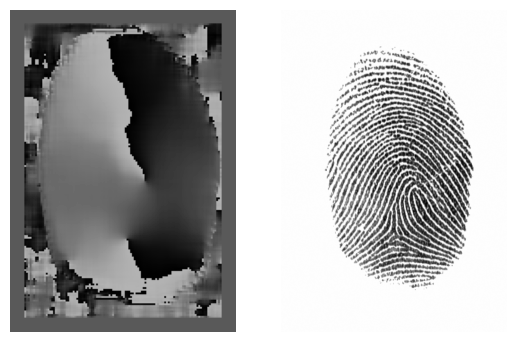

In [148]:
orientation_field_creator = OrientationFieldCreator(16)
if not os.path.exists("orientation_fields"): os.makedirs("orientation_fields")

def show(im1, im2):
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(im1, cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(im2)

orientation_field_image_01_01 = orientation_field_creator.create_field_for(image_01_01)
cv.imwrite("orientation_fields/orientation_field_image_01_01.png", orientation_field_image_01_01)
show(orientation_field_image_01_01, cv.imread('fingerprints/finger_print_01_01_C.bmp'))

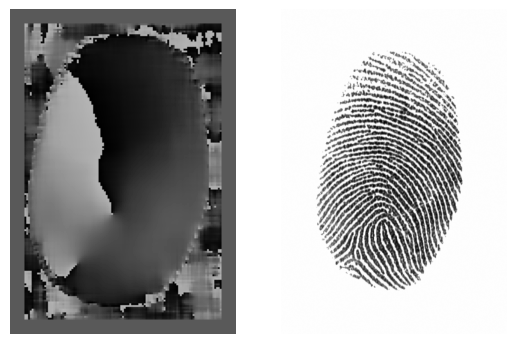

In [149]:
orientation_field_image_01_02 = orientation_field_creator.create_field_for(image_01_02)
cv.imwrite("orientation_fields/orientation_field_image_01_02.png", orientation_field_image_01_02)
show(orientation_field_image_01_02, cv.imread('fingerprints/finger_print_01_02_C.bmp'))

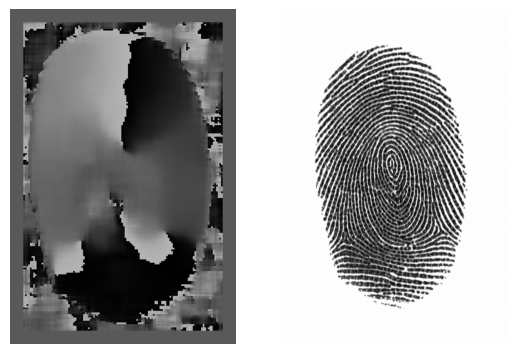

In [150]:
orientation_field_image_02 = orientation_field_creator.create_field_for(image_02)
cv.imwrite("orientation_fields/orientation_field_image_02.png", orientation_field_image_02)
show(orientation_field_image_02, cv.imread('fingerprints/finger_print_06.bmp'))

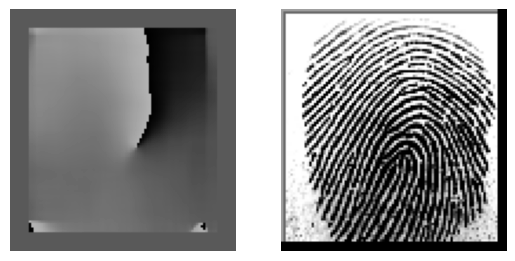

In [151]:
orientation_field_image_03 = orientation_field_creator.create_field_for(image_03)
cv.imwrite("orientation_fields/orientation_field_image_03.png", orientation_field_image_03)
show(orientation_field_image_03, cv.imread('fingerprints/example_0.bmp'))

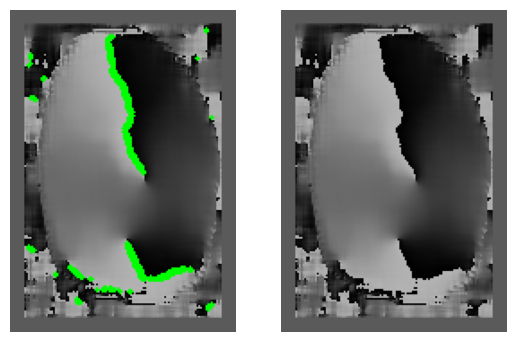

In [152]:
class HighContrastPointDetector:
    def __init__(self, std):
        self.std = std

    def calculate_for(self, image):
        total_gradient_change = self._calculate_gradient(image)
        return np.argwhere(total_gradient_change > self._contrast_threshold(total_gradient_change))

    def _contrast_threshold(self, total_gradient_change):
        return np.mean(total_gradient_change) + self.std * np.std(total_gradient_change)

    def _calculate_gradient(self, image):
        sobel_x_abs = np.abs(cv.Sobel(image, cv.CV_64F, 1, 0, ksize=11))
        sobel_y_abs = np.abs(cv.Sobel(image, cv.CV_64F, 0, 1, ksize=11))
        return sobel_x_abs + sobel_y_abs


def create_image_with_hc(image):
    result = image.copy()
    for point in HighContrastPointDetector(3.7).calculate_for(image):
        cv.circle(result, (point[1], point[0]), 1, (0, 255, 0), -1)
    return result

image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_01_01.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)

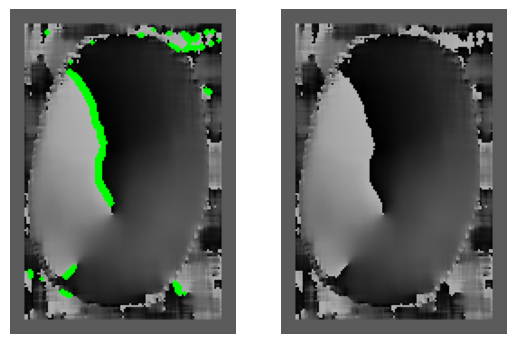

In [153]:
image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_01_02.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)

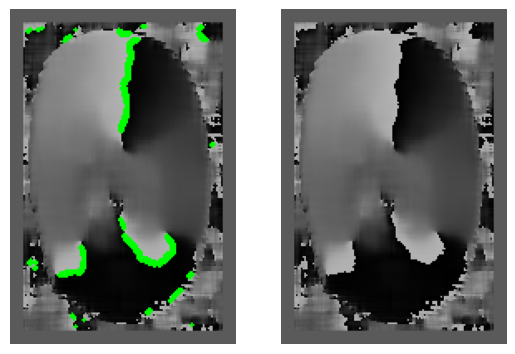

In [154]:
image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_02.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)

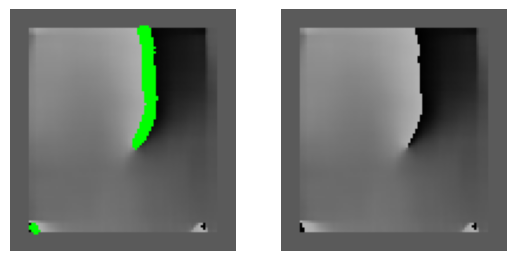

In [155]:
image = cv.cvtColor(cv.imread("orientation_fields/orientation_field_image_03.png", cv.COLOR_GRAY2BGR), cv.COLOR_GRAY2BGR)
show(create_image_with_hc(image), image)

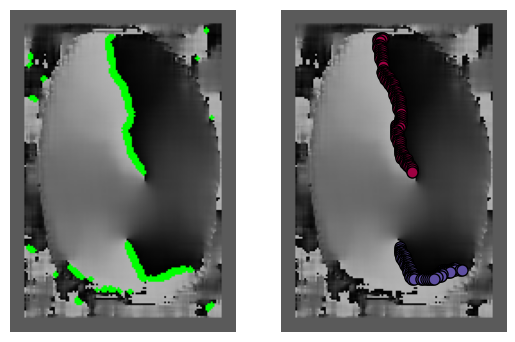

In [156]:
class ClusterCreator:
    def __init__(self, distance = 10, minimum_samples_per_cluster = 12):
        self.distance = distance
        self.minimum_samples_per_cluster = minimum_samples_per_cluster

    def calculate(self, points):
        return self._create_dictionary(DBSCAN(eps=self.distance, min_samples=self.minimum_samples_per_cluster)
                                       .fit(points), points)

    def _create_dictionary(self, clustering, points):
        clusters = defaultdict(lambda: [])
        for label, point in zip(clustering.labels_, points):
            if label != -1: clusters[label].append(point)
        return clusters

def show_cluster(image, clusters):
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(create_image_with_hc(cv.cvtColor(image, cv.COLOR_GRAY2BGR)), cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(clusters))]
    for label, (color, points) in enumerate(zip(colors, clusters.values())):
        cluster_points = np.array(points)
        plt.plot(cluster_points[:, 1], cluster_points[:, 0], 'o', markerfacecolor=tuple(color), markeredgecolor="k", markersize=8)

image = cv.imread("orientation_fields/orientation_field_image_01_01.png", cv.COLOR_GRAY2BGR)
hc_points = HighContrastPointDetector(4).calculate_for(image)
dictionary = ClusterCreator().calculate(hc_points)
show_cluster(image, dictionary)

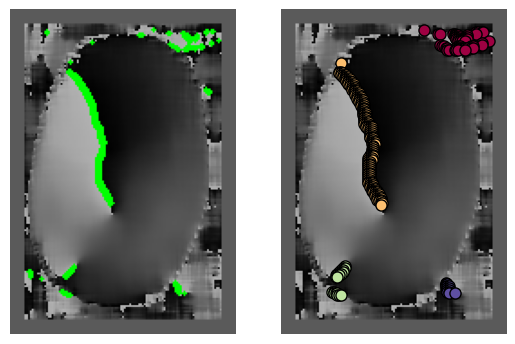

In [157]:
image = cv.imread("orientation_fields/orientation_field_image_01_02.png", cv.COLOR_GRAY2BGR)
hc_points = HighContrastPointDetector(3.7).calculate_for(image)
dictionary = ClusterCreator().calculate(hc_points)
show_cluster(image, dictionary)

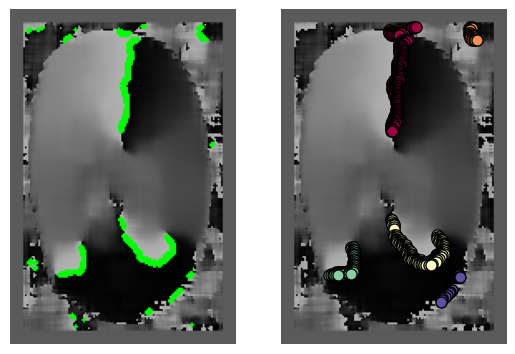

In [158]:
image = cv.imread("orientation_fields/orientation_field_image_02.png", cv.COLOR_GRAY2BGR)
hc_points = HighContrastPointDetector(3.7).calculate_for(image)
dictionary = ClusterCreator().calculate(hc_points)
show_cluster(image, dictionary)

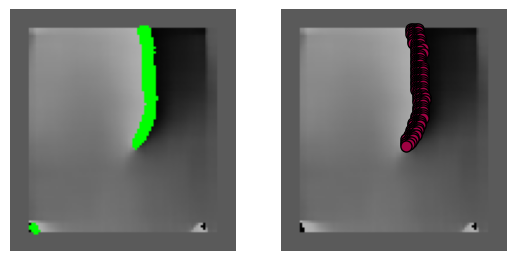

In [159]:
image = cv.imread("orientation_fields/orientation_field_image_03.png", cv.COLOR_GRAY2BGR)
hc_points = HighContrastPointDetector(3.7).calculate_for(image)
dictionary = ClusterCreator().calculate(hc_points)
show_cluster(image, dictionary)

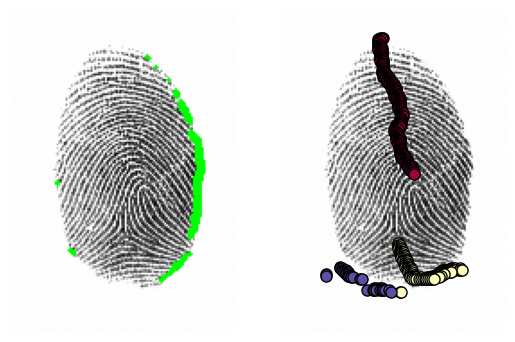

In [180]:
resizer = ImageProportionalResizer()
orientation_field_creator = OrientationFieldCreator(16)
hc_detector = HighContrastPointDetector(3.7)
cluster_creator = ClusterCreator(distance=10, minimum_samples_per_cluster=12)

class Fingerprint:
    def __init__(self, name, fingerprint_image):
        self.name = name
        self.resized_image = resizer.resize(fingerprint_image) if fingerprint_image.shape[0] > 200 else fingerprint_image
        self.orientation_field = orientation_field_creator.create_field_for(self.resized_image)
        self.hc_points = hc_detector.calculate_for(self.orientation_field)
        self.clusters = cluster_creator.calculate(self.hc_points)


fingerprint_01_01 = Fingerprint("finger_print_01_01", cv.imread("fingerprints/finger_print_01_01_C.bmp", cv.COLOR_GRAY2BGR))
fingerprint_01_02 = Fingerprint("finger_print_01_02", cv.imread("fingerprints/finger_print_01_02_C.bmp", cv.COLOR_GRAY2BGR))
fingerprint_02 = Fingerprint("finger_print_02", cv.imread("fingerprints/finger_print_06.bmp", cv.COLOR_GRAY2BGR))
fingerprint_03 = Fingerprint("fingerprint_03", cv.imread("fingerprints/example_0.bmp", cv.COLOR_GRAY2BGR)[:, :, 0])

show_cluster(fingerprint_01_01.resized_image, fingerprint_01_01.clusters)

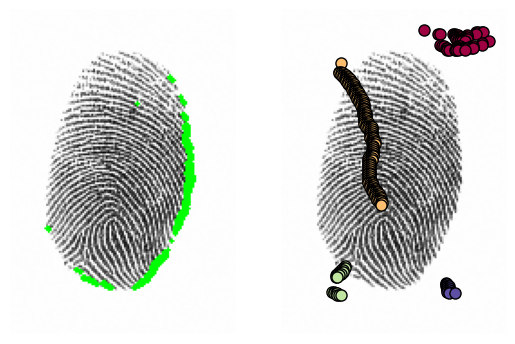

In [181]:
show_cluster(fingerprint_01_02.resized_image, fingerprint_01_02.clusters)

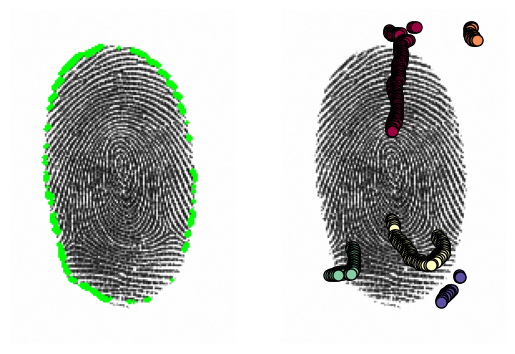

In [182]:
show_cluster(fingerprint_02.resized_image, fingerprint_02.clusters)

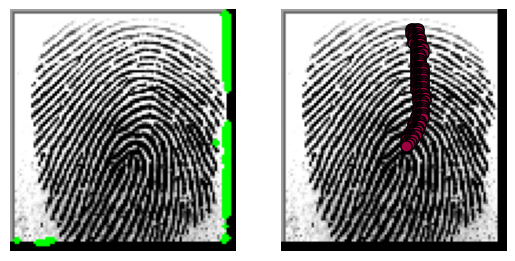

In [183]:
show_cluster(fingerprint_03.resized_image, fingerprint_03.clusters)

In [198]:
finger_prints = [fingerprint_01_01, fingerprint_01_02, fingerprint_02, fingerprint_03]
names = ["fingerprint_01_01", "fingerprint_01_02", "fingerprint_02", "fingerprint_03"]

class DistanceCalculator:
    def _calculate_cluster_distances(self, cluster1, cluster2):
        distances = []
        for point1 in cluster1:
            for point2 in cluster2:
                distances.append(np.linalg.norm(point1 - point2))
        return distances if distances else [np.inf]

    def distance_for(self, finger_print_1, finger_print_2):
        min_distances = []
        for cluster_label1, cluster1 in finger_print_1.clusters.items():
            for cluster_label2, cluster2 in finger_print_2.clusters.items():
                distances = self._calculate_cluster_distances(cluster1, cluster2)
                min_distance = np.mean(distances)
                min_distances.append(min_distance)
        return np.mean(min_distances) if min_distances else np.inf

calculator = DistanceCalculator()

def not_computed(i, j):
    return i < j

fingerprint_comparison_results = {}
for i, fingerprint1 in enumerate(finger_prints):
    for j, fingerprint2 in enumerate(finger_prints):
        if not_computed(i, j):
            fingerprint_comparison_results[f"{names[i]} vs {names[j]}"] = calculator.distance_for(fingerprint1, fingerprint2)

fingerprint_comparison_results

{'fingerprint_01_01 vs fingerprint_01_02': 72.39237294653945,
 'fingerprint_01_01 vs fingerprint_02': 75.74690275646624,
 'fingerprint_01_01 vs fingerprint_03': 87.4695552568483,
 'fingerprint_01_02 vs fingerprint_02': 83.36439661619526,
 'fingerprint_01_02 vs fingerprint_03': 83.93231011571305,
 'fingerprint_02 vs fingerprint_03': 94.25945362436205}

In [200]:
class FingerPrintDistanceDTO:
    def __init__(self, finger_print, distance):
        self.fingerprint = finger_print
        self.distance = distance

    def __str__(self):
        return self.fingerprint.name + " --> " + str(self.distance)

class FingerPrintComparator:
    def __init__(self, finger_prints):
        self._fingerprints = finger_prints
        self._distance_calculator = DistanceCalculator()

    def fingerprint_similar_to(self, this_finger_print):
        result = FingerPrintDistanceDTO(None, sys.maxsize)
        for finger_print in self._fingerprints:
            result = self.assign_to(result, self._distance_calculator.distance_for(this_finger_print, finger_print), finger_print)
        return result

    def assign_to(self, result, distance, finger_print):
        return FingerPrintDistanceDTO(finger_print, distance) if distance < result.distance else result

comparator = FingerPrintComparator([fingerprint_01_01, fingerprint_03, fingerprint_02])
print(comparator.fingerprint_similar_to(fingerprint_01_02))

finger_print_01_01 --> 72.39237294653947
